In [1]:
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient
from autogen_agentchat.teams import SelectorGroupChat
from autogen_agentchat.agents import AssistantAgent
from autogen_core.tools import FunctionTool
from autogen_agentchat.conditions import TextMentionTermination,MaxMessageTermination
from autogen_agentchat.ui import  Console
from langchain_tavily import TavilySearch



# Create the token provider
token_provider = get_bearer_token_provider(
    DefaultAzureCredential(),
    "https://cognitiveservices.azure.com/.default",
)

model_client = AzureOpenAIChatCompletionClient(
    azure_deployment="gpt-4o-mini",
    model="gpt-4o-mini",
    api_version="2024-08-01-preview",
    azure_endpoint="https://azopenai-langchain.openai.azure.com/",
    azure_ad_token_provider=token_provider,  # Optional if you choose key-based authentication.
    # api_key="sk-...", # For key-based authentication.
)


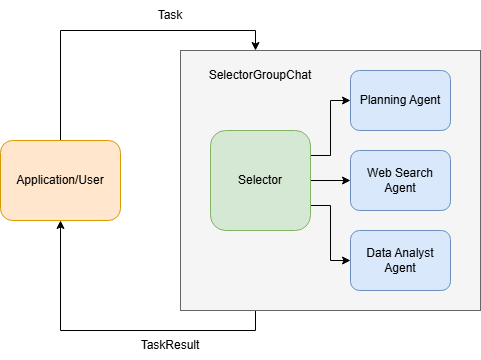

In [10]:
import os
from dotenv import load_dotenv


load_dotenv()
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
tavily_tool = TavilySearch( 
    api_key=TAVILY_API_KEY,
    max_results=1
)

def search_web(query: str) -> str:
    """Search the web for a given query and return the top result."""
    print(f"Searching for: {query}")
    if not query:
        return "No query provided."
    results = tavily_tool.run(query)
    #print(f"Search results: {results}")
    if not results:
        return "No results found."
    if results:
        return results
    else:
        return "No results found."
    

    
def percentage_change(start: float, end: float) -> float:
    return ((end - start) / start) * 100


In [11]:
search_tool = FunctionTool(name="search_web_tool",description="Searches the web for information.",func=search_web)
percentage_change_tool= FunctionTool(name="percentage_change_tool",description="Calculates the percentage change between two numbers.",func=percentage_change)

In [12]:
planning_agent = AssistantAgent(
    "PlanningAgent",
    description="An agent for planning tasks, this agent should be the first to engage when given a new task.",
    model_client=model_client,
    system_message="""
    You are a planning agent.
    Your job is to break down complex tasks into smaller, manageable subtasks.
    Your team members are:
        WebSearchAgent: Searches for information
        DataAnalystAgent: Performs calculations

    You only plan and delegate tasks - you do not execute them yourself.

    When assigning tasks, use this format:
    1. <agent> : <task>

    After all tasks are complete, summarize the findings and end with "TERMINATE".
    """,
)

web_search_agent = AssistantAgent(
    "WebSearchAgent",
    description="An agent for searching information on the web.",
    tools=[search_tool],
    model_client=model_client,
    system_message="""
    You are a web search agent.
    Your only tool is search_tool - use it to find information.
    You make only one search call at a time.
    Once you have the results, you never do calculations based on them.
    """,
)

data_analyst_agent = AssistantAgent(
    "DataAnalystAgent",
    description="An agent for performing calculations.",
    model_client=model_client,
    tools=[percentage_change_tool],
    system_message="""
    You are a data analyst.
    Given the tasks you have been assigned, you should analyze the data and provide results using the tools provided.
    If you have not seen the data, ask for it.
    """,
)

In [13]:
selector_prompt = """Select an agent to perform task.

{roles}

Current conversation context:
{history}

Read the above conversation, then select an agent from {participants} to perform the next task.
Make sure the planner agent has assigned tasks before other agents start working.
Only select one agent.
"""


In [14]:
text_mention_termination = TextMentionTermination("TERMINATE")
max_messages_termination = MaxMessageTermination(max_messages=25)
termination = text_mention_termination | max_messages_termination


In [15]:
team = SelectorGroupChat(
    [planning_agent, web_search_agent, data_analyst_agent],
    model_client=model_client,
    termination_condition=termination,
    selector_prompt=selector_prompt,
    allow_repeated_speaker=True,  # Allow an agent to speak multiple turns in a row.
)


In [ ]:
task = "Which Chennai Super Kings player hit the most sixes in 2025, and how did his batting average differ from his 2023 performance?"
# Use asyncio.run(...) if you are running this in a script.
await Console(team.run_stream(task=task))


---------- TextMessage (user) ----------
Which Chennai Super Kings player hit the most sixes in 2025, and how did his batting average differ from his 2023 performance?
---------- TextMessage (PlanningAgent) ----------
To gather the necessary information, we need to take the following steps:

1. WebSearchAgent : Search for the Chennai Super Kings player who hit the most sixes in the year 2025.
2. WebSearchAgent : Search for the batting average of that player in 2025.
3. WebSearchAgent : Search for the batting average of the same player in 2023.
4. DataAnalystAgent : Calculate the difference in batting averages between 2025 and 2023 for that player.

Once all the tasks are completed, I will summarize the findings.
---------- ToolCallRequestEvent (WebSearchAgent) ----------
[FunctionCall(id='call_FvMVyu6bEpSvQVqiVWFVgADz', arguments='{"query":"Chennai Super Kings player most sixes 2025"}', name='search_web_tool')]
---------- ToolCallExecutionEvent (WebSearchAgent) ----------
[FunctionExec

TaskResult(messages=[TextMessage(id='daccb589-fd33-47ce-b09c-35507bde472d', source='user', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 7, 19, 3, 1, 38, 134627, tzinfo=datetime.timezone.utc), content='Which Chennai Super Kings player hit the most sixes in 2025, and how did his batting average differ from his 2023 performance?', type='TextMessage'), TextMessage(id='ad99130a-f0d0-4468-90a9-7960554ed6de', source='PlanningAgent', models_usage=RequestUsage(prompt_tokens=143, completion_tokens=118), metadata={}, created_at=datetime.datetime(2025, 7, 19, 3, 1, 42, 152320, tzinfo=datetime.timezone.utc), content='To gather the necessary information, we need to take the following steps:\n\n1. WebSearchAgent : Search for the Chennai Super Kings player who hit the most sixes in the year 2025.\n2. WebSearchAgent : Search for the batting average of that player in 2025.\n3. WebSearchAgent : Search for the batting average of the same player in 2023.\n4. DataAnalystAgent : Calcula

Searching for: MS Dhoni batting average in 2025
Searching for: Chennai Super Kings player 2023 IPL batting average
Searching for: Rachin Ravindra 2023 IPL batting average
Searching for: Chennai Super Kings player most sixes 2025 IPL site:indianexpress.com


In [17]:
#### Custom Agent
from autogen_agentchat.messages import BaseAgentEvent, BaseChatMessage
from typing import Sequence

def selector_func(messages: Sequence[BaseAgentEvent | BaseChatMessage]) -> str | None:
    if messages[-1].source != planning_agent.name:
        return planning_agent.name
    return None

In [18]:
# Reset the previous team and run the chat again with the selector function.
await team.reset()
team = SelectorGroupChat(
    [planning_agent, web_search_agent, data_analyst_agent],
    model_client=model_client,
    termination_condition=termination,
    selector_prompt=selector_prompt,
    allow_repeated_speaker=True,
    selector_func=selector_func,
)

await Console(team.run_stream(task=task))

---------- TextMessage (user) ----------
Which Chennai Super Kings player hit the most sixes in 2025, and how did his batting average differ from his 2023 performance?
---------- TextMessage (PlanningAgent) ----------
To find out which Chennai Super Kings player hit the most sixes in 2025 and to compare his batting average in 2025 with that in 2023, the following tasks need to be carried out:

1. WebSearchAgent : Search for the Chennai Super Kings player who hit the most sixes in the 2025 season.
2. WebSearchAgent : Search for the batting average of the identified player in the year 2025.
3. WebSearchAgent : Search for the batting average of the identified player in the year 2023.
4. DataAnalystAgent : Calculate the difference in the batting averages from 2023 to 2025.

After all tasks are complete, I will summarize the findings.
---------- ToolCallRequestEvent (WebSearchAgent) ----------
[FunctionCall(id='call_4hSmD6ign9Vf03nIW3NM2UZS', arguments='{"query":"Chennai Super Kings player 

TaskResult(messages=[TextMessage(id='ec43a07c-c5af-4c1f-ab4c-db7696a81596', source='user', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 7, 19, 3, 3, 32, 989662, tzinfo=datetime.timezone.utc), content='Which Chennai Super Kings player hit the most sixes in 2025, and how did his batting average differ from his 2023 performance?', type='TextMessage'), TextMessage(id='0c3b5654-ea59-42c8-bf49-6378dbb1736f', source='PlanningAgent', models_usage=RequestUsage(prompt_tokens=143, completion_tokens=149), metadata={}, created_at=datetime.datetime(2025, 7, 19, 3, 3, 35, 775450, tzinfo=datetime.timezone.utc), content='To find out which Chennai Super Kings player hit the most sixes in 2025 and to compare his batting average in 2025 with that in 2023, the following tasks need to be carried out:\n\n1. WebSearchAgent : Search for the Chennai Super Kings player who hit the most sixes in the 2025 season.\n2. WebSearchAgent : Search for the batting average of the identified player in 

In [ ]:
#### Candidate Func
from typing import List, Sequence

def candidate_func(messages: Sequence[BaseAgentEvent | BaseChatMessage]) -> List[str]:
    # keep planning_agent first one to plan out the tasks
    if messages[-1].source == "user":
        return [planning_agent.name]

    # if previous agent is planning_agent and if it explicitely asks for web_search_agent
    # or data_analyst_agent or both (in-case of re-planning or re-assignment of tasks)
    # then return those specific agents
    last_message = messages[-1]
    if last_message.source == planning_agent.name:
        participants = []
        if web_search_agent.name in last_message.to_text():
            participants.append(web_search_agent.name)
        if data_analyst_agent.name in last_message.to_text():
            participants.append(data_analyst_agent.name)
        if participants:
            return participants  # SelectorGroupChat will select from the remaining two agents.

    # we can assume that the task is finished once the web_search_agent
    # and data_analyst_agent have took their turns, thus we send
    # in planning_agent to terminate the chat
    previous_set_of_agents = set(message.source for message in messages)
    if web_search_agent.name in previous_set_of_agents and data_analyst_agent.name in previous_set_of_agents:
        return [planning_agent.name]

    # if no-conditions are met then return all the agents
    return [planning_agent.name, web_search_agent.name, data_analyst_agent.name]


# Reset the previous team and run the chat again with the selector function.
await team.reset()
team = SelectorGroupChat(
    [planning_agent, web_search_agent, data_analyst_agent],
    model_client=model_client,
    termination_condition=termination,
    candidate_func=candidate_func,
)

await Console(team.run_stream(task=task))


---------- TextMessage (user) ----------
Which Chennai Super Kings player hit the most sixes in 2025, and how did his batting average differ from his 2023 performance?
---------- TextMessage (PlanningAgent) ----------
To address your query, we need to gather two pieces of information:

1. Identify which Chennai Super Kings player hit the most sixes in the 2025 season.
2. Compare that player's batting average in 2025 to their batting average in the 2023 season.

I'll delegate the tasks as follows:

1. WebSearchAgent : Find out which Chennai Super Kings player hit the most sixes in the 2025 IPL season.
2. WebSearchAgent : Find the batting average of the identified player in the 2025 IPL season.
3. WebSearchAgent : Find the batting average of the same player in the 2023 IPL season.
4. DataAnalystAgent : Compare the batting averages of the player in 2025 and 2023, and determine the difference.

Please proceed with these tasks.
---------- ToolCallRequestEvent (WebSearchAgent) ----------
[Fu

TaskResult(messages=[TextMessage(id='939973ee-225d-42be-a2b0-06179b83dc27', source='user', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 7, 19, 3, 22, 12, 35387, tzinfo=datetime.timezone.utc), content='Which Chennai Super Kings player hit the most sixes in 2025, and how did his batting average differ from his 2023 performance?', type='TextMessage'), TextMessage(id='0e6be9db-9204-4bc2-b8e5-4fcb6955773b', source='PlanningAgent', models_usage=RequestUsage(prompt_tokens=143, completion_tokens=168), metadata={}, created_at=datetime.datetime(2025, 7, 19, 3, 22, 14, 961861, tzinfo=datetime.timezone.utc), content="To address your query, we need to gather two pieces of information:\n\n1. Identify which Chennai Super Kings player hit the most sixes in the 2025 season.\n2. Compare that player's batting average in 2025 to their batting average in the 2023 season.\n\nI'll delegate the tasks as follows:\n\n1. WebSearchAgent : Find out which Chennai Super Kings player hit the mos

Searching for: Chennai Super Kings player most sixes 2025 IPL season
Searching for: Chennai Super Kings player who hit most sixes IPL 2025


In [21]:

from autogen_agentchat.agents import UserProxyAgent
user_proxy_agent = UserProxyAgent("UserProxyAgent", description="A proxy for the user to approve or disapprove tasks.")


def selector_func_with_user_proxy(messages: Sequence[BaseAgentEvent | BaseChatMessage]) -> str | None:
    if messages[-1].source != planning_agent.name and messages[-1].source != user_proxy_agent.name:
        # Planning agent should be the first to engage when given a new task, or check progress.
        return planning_agent.name
    if messages[-1].source == planning_agent.name:
        if messages[-2].source == user_proxy_agent.name and "APPROVE" in messages[-1].content.upper():  # type: ignore
            # User has approved the plan, proceed to the next agent.
            return None
        # Use the user proxy agent to get the user's approval to proceed.
        return user_proxy_agent.name
    if messages[-1].source == user_proxy_agent.name:
        # If the user does not approve, return to the planning agent.
        if "APPROVE" not in messages[-1].content.upper():  # type: ignore
            return planning_agent.name
    return None


# Reset the previous agents and run the chat again with the user proxy agent and selector function.
await team.reset()
team = SelectorGroupChat(
    [planning_agent, web_search_agent, data_analyst_agent, user_proxy_agent],
    model_client=model_client,
    termination_condition=termination,
    selector_prompt=selector_prompt,
    selector_func=selector_func_with_user_proxy,
    allow_repeated_speaker=True,
)

await Console(team.run_stream(task=task))


---------- TextMessage (user) ----------
Which Chennai Super Kings player hit the most sixes in 2025, and how did his batting average differ from his 2023 performance?
---------- TextMessage (PlanningAgent) ----------
To find out which Chennai Super Kings player hit the most sixes in 2025 and to compare their batting average from 2023 to 2025, I will assign tasks to the agents.

1. WebSearchAgent : Search for the Chennai Super Kings player who hit the most sixes in the 2025 IPL season.
2. WebSearchAgent : Search for the batting average of the same player in the 2023 IPL season.
3. DataAnalystAgent : Calculate the difference in batting average between the player's performance in 2023 and 2025. 

Once these tasks are completed, I will summarize the findings.
---------- TextMessage (UserProxyAgent) ----------
Approve
---------- ToolCallRequestEvent (WebSearchAgent) ----------
[FunctionCall(id='call_eSVWtq6vYmHztIjySUZv0Rll', arguments='{"query": "Chennai Super Kings player most sixes 2025

TaskResult(messages=[TextMessage(id='51d44829-c6f8-4bf5-9e06-75ef8779aa32', source='user', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 7, 19, 3, 25, 37, 690892, tzinfo=datetime.timezone.utc), content='Which Chennai Super Kings player hit the most sixes in 2025, and how did his batting average differ from his 2023 performance?', type='TextMessage'), TextMessage(id='905dea68-7613-4778-97bd-5471c309c212', source='PlanningAgent', models_usage=RequestUsage(prompt_tokens=143, completion_tokens=130), metadata={}, created_at=datetime.datetime(2025, 7, 19, 3, 25, 40, 398195, tzinfo=datetime.timezone.utc), content="To find out which Chennai Super Kings player hit the most sixes in 2025 and to compare their batting average from 2023 to 2025, I will assign tasks to the agents.\n\n1. WebSearchAgent : Search for the Chennai Super Kings player who hit the most sixes in the 2025 IPL season.\n2. WebSearchAgent : Search for the batting average of the same player in the 2023 IPL se